# Project: Gradients and Solvers

## Machine Learning, Fall 2021

### Name: [Your name here]

### Sources
* _Add any and all sources here, including peers with whom your worked, websites, and other resources used._

In this project, you'll perform the following tasks:

1. [Explore gradients and contour plots](#Gradients-and-Contour-Plots),
2. [Learn about the notion of a "Blackbox" algorithm](#Learning-about-the-black-box)
2. [Define a `Variable` class](#The-Variable-class) which is used to compute the gradient of an "arbitrary" function,
3. [Test out your `Variable` class](#A-basic-test-of-your-Variable-class) by plotting some more gradients on contour plots, 
4. [Build and test a `LogisticRegression` class](#The-LogisticRegression-class) using your `Variable` class, and 
6. [Explore your fit model to ask questions about the black box](#Exploring-the-black-box)

In [1]:
# Standard import statements:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

plt.style.use("ggplot")

## Gradients and Contour Plots

Let's begin by understanding how contour plots work.  These are 2D representations of functions of two variables (what some people might call "3D functions").  You may be familiar with [contour maps](http://sitesmedia.s3.amazonaws.com/creekconnections/files/2014/09/topomap.jpg); a contour map is simply a contour plot of the function 

$$f(\text{lattitude}, \text{longitude}) = \left<\text{height of the Earth's surface above sea level at that point}\right>.$$ 

More generally, the contours in a plot are the paths of same height.  Thus, traveling perpendicularly to a contour means traveling "straight up or down the mountain".  Here's a first attempt at making a contour plot for a function which somewhat resembles the top of a mountain:

Exception was raised: 
TypeError: Input z must be 2D, not 1D


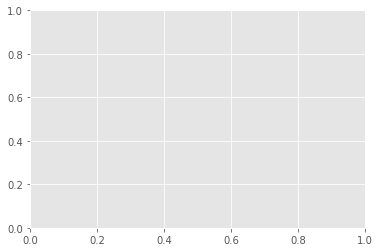

In [2]:
def f(x,y):
    return 1.2 - 0.2*x**2 - 0.3*y**2 + 0.1 * x * y - 0.25 * x

x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

# maybe a first guess is:
z = f(x,y)

try:
    plt.contour(x, y, z);
except Exception as e:
    print("Exception was raised: \n", type(e).__name__, ": ", e, sep='')

That doesn't work, because this only plugs values into $f$ which are on the *diagonal*, that is, those values in the $xy$-plane where $x=y$.  In order to make this work, we need a function value over every point in our grid, i.e. every pair of $x$- and $y$-values in the square.  This is why the value for z must be 2D, because its indices `i` and `j` are the indices of its $x$- and $y$-values of its point.  That is, `z[i,j] = f(x[i], y[j])`.

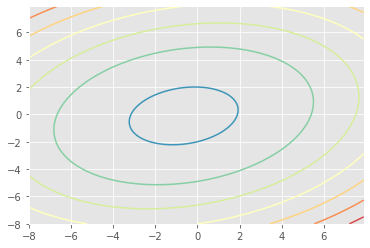

In [3]:
# Better, but super confusing. Try to parse this line:
z = np.array([[f(x[i],y[j]) for i in range(x.shape[0])] for j in range(y.shape[0])])

try:
    plt.contour(x, y, z, cmap='Spectral');
except Exception as e:
    print(e)

That works, but that line defining `z` sure was a slog.  This is where the helper function `np.meshgrid` comes into play:

In [4]:
X, Y = np.meshgrid(x, y)
Z = f(X,Y)

# Convenience for printing 
iters = [('x', x), ('X', X), ('y', y), ('Y', Y), ('z', z) , ('Z', Z)]

for name, var in iters:
    print("The shape of {} is {}".format(name, var.shape))

if (z == Z).all():
    print("\nThese ways work the same")

The shape of x is (160,)
The shape of X is (160, 160)
The shape of y is (160,)
The shape of Y is (160, 160)
The shape of z is (160, 160)
The shape of Z is (160, 160)


So `np.meshgrid` is used to build this `Z` (which is the same as our manually-built `z`).  But what are `X` and `Y`?

In [5]:
## Make sure you understand what the following code is doing!  It will help with understanding X and Y.

for name, var in iters[:4]:
    try:
        snipped = var[:6, :6]
    except:
        snipped = var[:6]
    print('Beginning of {}:\n{}'.format(name, snipped), end='\n\n')

Beginning of x:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

Beginning of X:
[[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]]

Beginning of y:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

Beginning of Y:
[[-8.  -8.  -8.  -8.  -8.  -8. ]
 [-7.9 -7.9 -7.9 -7.9 -7.9 -7.9]
 [-7.8 -7.8 -7.8 -7.8 -7.8 -7.8]
 [-7.7 -7.7 -7.7 -7.7 -7.7 -7.7]
 [-7.6 -7.6 -7.6 -7.6 -7.6 -7.6]
 [-7.5 -7.5 -7.5 -7.5 -7.5 -7.5]]



**Response:** meshgrid basically stacks a linearly increasing gradient in x direction across all y values and then stack a linearly increasing gradient in y direction across all x values. This allows us to obtain the x, y value at a specific point quickly by doing X[x, y] and Y[x, y]

Okay, so now that we know how to plot contour plots of functions of 2 variables, let's explore adding some **gradients** to the plot.  First we define a helper function, used to help us draw the arrows on contour plots

In [6]:
def draw_arrow(a, b, c, d, ax=None):
    """ Draw an arrow on a plot.
    
    params:
        a, b -- coordinates of the base of the arrow
        c, d -- vector corresponding to the arrow (starting at the origin)
        ax   -- the matplotlib Axes object on which to draw the arrow.  If none, set to current Axes object.
    """
    ax = ax or plt.gca()
    v_0 = np.array([a,b])
    v_1 = np.array([c,d]) + v_0
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color='k')
    plt.annotate('', v_1, v_0, arrowprops=arrowprops)

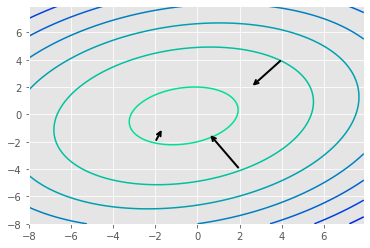

In [7]:
# Plot the contour plot as well as some gradient vectors
x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

X, Y = np.meshgrid(x,y)
Z = f(X,Y)

plt.contour(x, y, Z, cmap='winter')

# Draw some gradients
draw_arrow(2, -4, -1.45,  2.6)
draw_arrow(-2, -2, 0.35, 1)
draw_arrow(4, 4, -1.45, -2)


Okay, so now here's your task. The gradient of the above function happens to be:
$$\nabla f(x,y) = \left<-.4 x + .1 y - .25, -.6 y + .1 x\right>.$$ 

What this means is: at any point $(x, y)$, the gradient is a vector whose $x$- and $y$-components are given by the right-hand side of the equation. You don't need to know how to compute that gradient.
    
Create a function `draw_gradient` that, given a point $(x,y)$, draws the gradient of $f$ at that point.  Then, in the same cell below, recreate the above plot so that your `draw_gradient` method gets called for a handful of randomly-generated points (so that you can rerun the cell and get a new handful of gradient vectors drawn each time).

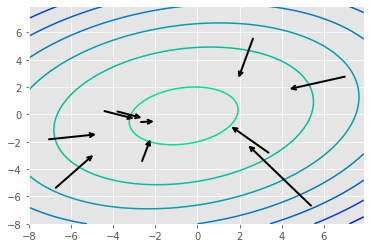

In [8]:
# Good luck!
def draw_gradient(x, y):
    def gradient(x, y):
        return -0.4*x+0.1*y-0.25, -0.6*y+0.1*x
    x1, y1 = gradient(x, y)
    draw_arrow(x,y,x1,y1)

# Plot the contour plot as well as some gradient vectors
x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

X, Y = np.meshgrid(x,y)
Z = f(X,Y)

plt.contour(x, y, Z, cmap='winter')

Xs = np.random.uniform(-8,8,10)
Ys = np.random.uniform(-8,8,10)
for i in range(10):
    x = np.random.uniform(-8,8)
    y = np.random.uniform(-8,8)
    draw_gradient(x,y)


Rules for Gradients:

As we have seen, the gradient is a function that points us "up the hill", in the direction of steepest increase of a function $f$.  What does that mean?  It's important to keep in mind that if you have a function $f$ then the gradient of $f$, written as $\nabla f$, is a different function that takes in points from the same space $f$ does and outputs a vector which points up toward the direction of steepest increase at that point.

Below are all the rules that we will need for our gradients.  In a multivariable calculus class, you would study and possibly even prove these statements.  For us, we'll take them as our programming requirements: the gradient is simply a recursive function with a bunch of rules.  Do not feel like you need to memorize these for my class, or understand where they come from. I will never ask you to compute the gradient of a function by hand.


If $x_i$ is the $i^{\text{th}}$ independent variable, then $\nabla x_i = \left<0,\ldots,0,1,0,\ldots, 0\right>$, where the $1$ is in the $i^{\text{th}}$ slot.  Another way to say this is the following.  Suppose my function $f$ just picked out the $i^{\text{th}}$ variable: $f(x_1, \ldots, x_p)=x_i$, for some $i$.  Then the gradient of $f$ would be length 1 and would point in the $x_i$-direction.
The gradient is linear: 
  If $f(x_1, \ldots, x_p) = w_1+w_2$, then $\nabla f = \nabla w_1 + \nabla w_2$, and 
  If $f(x_1, \ldots, x_p) = c \cdot w$, then $\nabla f = c \cdot \nabla w$.
  (As an extension of the first point: if $f(x_1, \ldots, x_p) = \sum_{i=1}^n w_i$, then $\nabla f = \sum_{i=1}^n\nabla w_i$.)
The gradient has a power rule: 
If $f(x_1, \ldots, x_p) = w^n$ then $\nabla f = n w^{n-1} \cdot \nabla w$, 
The gradient has a product rule: 
 If $f(x_1, \ldots, x_p) = w_1\cdot w_2$ then $\nabla f = w_1 \cdot \nabla w_2 + w_2 \cdot \nabla w_1$,
   The gradient does have a difference rule and a quotient rule, but you can just define yours using the facts that $w_1 - w_2 = w_1 + (-1) \cdot w_2$ and $\dfrac{w_1}{w_2} = w_1 \cdot (w_2)^{-1}$, respectively.
The gradient has a chain rule, which manifests itself in the following ways (the only ones we'll need):

  If $f(x_1, \ldots, x_p) = e^w$ then $\nabla f = e^w \cdot \nabla w$,
  If $f(x_1, \ldots, x_p) = \ln(w)$ then $\nabla f = \frac{1}{w} \cdot \nabla w$, 
  There are lots of others, but we won't need them for now. 


# Learning about the black box

One of the most common conversation points written about machine learning, and artificial intelligence more generally, is the notion that machine learning algorithms are "black boxes". Roughly, this means that the programmer creates the code which _trains_ the algorithm, runs that training code, then has _no idea_ what's going on "inside the box" of their machine learning model. Another goal for you in this project is to gain a more nuanced understanding of this argument. I want you to do a little bit of research now, and then explore later, the following questions:

* What does it mean to say that the creator of a machine learning model "doesn't know what's going on inside their algorithm"? What don't they know? _(hint: it has to do with parameters.)_
* Do machine learning model creators truly have _no idea_ what happens in their models? Perhaps, by default they don't? Or, in practice, they don't? 

You can find whatever resources you want on this topic (and if you find a resource you especially like, _definitely_ share with us all!). Here are some articles for you to explore if you need some help.

* [The dangers of trusting black-box machine learning](https://bdtechtalks.com/2020/07/27/black-box-ai-models/), by Ben Dickson
* [Code-Dependent: Pros and Cons of the Algorithm Age](https://www.pewresearch.org/internet/2017/02/08/code-dependent-pros-and-cons-of-the-algorithm-age/)By Lee Rainie and Janna Anderson. This article is HUGE, and covers many conversations. The point we're looking for in here is the last one, "Theme 7: The need grows for algorithmic literacy, transparency and oversight".
* [Machine Learning Algorithms are Not Black Boxes](https://towardsdatascience.com/machine-learning-algorithms-are-not-black-boxes-541ddaf760c3), by Zach Monge. This explores neural networks, which we haven't covered yet, but for now, just know that they are very similar to linear and logistic regression, just with thousands of parameters instead of just a handful ($m$ and $b$, or in a multidimensional version, $m_1, m_2, \ldots, m_m$, and $b$).

<div style="background-color: #EFDDFF; padding: 10px;">
    <p>Provide a reflection here about your findings.</p>
    </div>

After researching about AI explainability, I found the following:
A deep learning algorithm always try to approximate some ideal classification/regression function through its multitude of layers of linear composition + nonlinearity. We say such a model is a blackbox because it's virtually impossible for us to obtain in analytic or any other form, this function that we try to approximate just by inspecting the parameters of the model. This task is theorectically possible--we can just record the output of our model for every possible input in the input space--but is practically impossible due to the computational costs. Therefore, ML algorithms are practical black boxes. Through reading the article on the "dangers of trusting black-box ...", I learned that black box models are potentially dangerous because they can perform unexpectedly in inference especially for data it has never seen before. 

Black box ML sometimes also refer to corporations keeping their ML products proprietary and thus making it unpredictable to the end users, which could make controversial decisions. 

## The `Variable` class

Your main task in the project is to make a `Variable` class.  The `Variable` class is a node in the computational graph.  It should have the following attributes and methods:

* an `__init__` method,
* an `evaluate` method that allows you to evaluate the variable at a given value of the primitive (independent) variables,
* a `grad` method that will compute return the gradient at a given value.  Here, you should use a numpy array. This might sound scary, but the main reason is so that you can compute with them nicely, later (see my implementation of a `grad` method below).  For example, to do this for $f(x_1, x_2, x_3) = x_1$, that `Variable`'s gradient function should `return np.array([1,0,0])`
* appropriate methods/functionality to calculate the gradients and function evaluation for all the gradients defined above.
* _(Optional)_ I found it helpful to have a class attribute called `all_variables` which is a list that keeps track of all the Variable objects in the order of creation.  There are fancy technical definitions and requirements of such a list, technically called a _Wengert list_, but for you it could just be a list that holds all your `Variable` objects (so in the constructor, you should append `self` to the list). You definitely may not need this, but some people benefit from making it. 
 * If you do make this, you'll likely need a class method which resets the list to an empty list.  This allows you to redefine the expression each time you create a new computational graph. Google `@staticmethod` to see the notation.
* _(old, replaced by dictionary version_ an attribute `inputs`, a list that records which inputs the current `Variable` objects takes.  This could highly leverage your wengert list.

As an example, if I were to say:

```
>>> x = Variable()
>>> y = Variable()
>>> z = x + y
```

This will create a new `Variable` class for `z`, and initialize it appropriately, and give it the ability to take its gradient.  The way we can implement this is by defining a *magic* method called `__add__`.  Magic methods in Python are what give it such a great, readable API.  Here's an example `__add__` method, based on how I set up my constructor.  Yours might be a little bit different:

```
    def __add__(self, other):
        """ Defines the functionality of the `+` operator. """
        if isinstance(other, (int, float)):
            """ The derivative of a constant is zero. """
            return Variable(
                                evaluate = lambda values: other + self.evaluate(values), 
                                grad = self.grad
                            )
        elif isinstance(other, Variable):
            """ The differential operator is linear. """
            return Variable(
                                evaluate = lambda values: self.evaluate(values) 
                                    + other.evaluate(values),
                                grad = lambda values: self.grad(values) 
                                    + other.grad(values)
                           )
        else:
            return NotImplemented
```

See [this link](http://www.diveintopython3.net/special-method-names.html#acts-like-number) to learn about the magic methods you will need to implement.

The theory here is that you create the "ugly" `x.__add__(y)`-ish code once and only once, and then when you use the code later it's much more readable: `x + y`.  You'll need to do something like this for all the operations discussed above in the [gradients section](#-Rules-for-Gradients:).  The exception is for functions like `exp` and `log` (and if I wanted you to do other things, like `sin`, `cos`, `tan`, _etc._).  Those will need to be class methods.  They should still return a new `Variable` object.  See below for the API that they should support.

Other methods you need to implement:

* While you do need to have an `evaluate` method, if you also implement the `__call__` method (make it just call `evaluate`) then you can replace code of the form `w.evaluate({"x_1": 4, "x_2": 2, "x_3": 8.5})` with `w(x_1 = 4, x_2 = 2, x_3 = 8.5)`, which is both cleaner and looks like function notation (which is desirable because the `w`'s really can be thought of as functions of the independent variables).
* You might want to implement the `__repr__` method so that you can print out your variables (as in, just `print(x)`).  It would be especially nice if printing out a `Variable` object gave you a graph traversal of its `inputs`.  It's okay here if it looks like a tree, _i.e._ nodes get repeated.  It would be a bit too much work to make the true graph visual happen.
* You will need to implement the methods `__radd__` and `__rmul__`, _etc._ that give your `__add__` and `__mul__` method more functionality.  This allows expressions like `2 + x` instead of always requiring that a user use the `Variable` object first: `x + 2`.  In your research, you may see `__iadd__` and `__imul__`, and those you _should_ skip.

Here are some resources that may help you along the way:
* A good explanation on [Automatic Differentiation](https://pdfs.semanticscholar.org/be3d/17df872d41465dabda2fc9a9a61394658a1a.pdf) (the name of this process).  It's probably _much_ more information than you need.
* There's always [Wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation).
* Another take on [operator overloading in Python](http://blog.teamtreehouse.com/operator-overloading-python).

## A "complete" collection of uses that demonstrates the API 
Suppose my function is: 

$$f(x_1, x_2, x_3) = e^{x_1 + {x_2}^2} + 3 \cdot \ln(27 - x_1\cdot x_2 \cdot x_3).$$

Then the following code would build and test my function. The first line might be different for you, depending on how you create the `exp` and `log` functions:

```
>>> from Variable import exp, log
>>> x_1 = Variable(name = "x_1")
>>> x_2 = Variable(name = "x_2")
>>> x_3 = Variable(name = "x_3")
>>> z = exp(x_1 + x_2**2) + 3 * log(27 - x_1 * x_2 * x_3)
>>> # Evaluate the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z(x_1 = 3, x_2 = 1, x_3 = 7)
59.9734284408284
>>> # Determine the gradient of the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z.grad(x_1 = 3, x_2 = 1, x_3 = 7)
array([ 51.09815003,  98.69630007,  -1.5       ])
>>> print(x_1 + x_2**2)
+(
 1: <input 1>
 2: ^2(
  <input 2>
 )
)
```
Two notes: 
1. I had to do some pencil-and-paper math on that gradient, let me know if it's not what you got!
2. The print-out is optional, but helpful!  You can make it say whatever you want.  Here, I made it list the node type, then indent the inputs of that node by one, recursively.  It almost looks a bit like [prefix notation](https://en.wikipedia.org/wiki/Polish_notation).

## Some thoughts on coding process

* I recommend that you don't actually define the class in a single cell in this notebook.  It's going to get a bit big, and it's going to be difficult to work on it together if it's in a cell on a jupyter notebook.  I believe that a better strategy for designing this class is to have a Python file `variable.py`, located in the same folder as this notebook and opened in your favorite text editor that contains your `Variable` class, and then just rerun a cell like this to reimport it here after saving over there:

In [9]:
from variable import Variable
x_1 = Variable(name = "x_1")
x_2 = Variable(name = "x_2")
x_3 = Variable(name = "x_3")
z = Variable.exp(x_1 + x_2**2) + 3 * Variable.log(27 - x_1 * x_2 * x_3)
# Evaluate the function at the point (x_1, x_2, x_3) = (3, 1, 7):
z(x_1 = 3, x_2 = 1, x_3 = 7)
# Determine the gradient of the function at the point (x_1, x_2, x_3) = (3, 1, 7):
z.grad(x_1 = 3, x_2 = 1, x_3 = 7)

array([51.09815003, 98.69630007, -1.5       ])

* Then, when you change something and want to check out how it works, just rerun the above cell.
* This also makes sharing code via something like github a lot easier!
* I _highly recommend_ you begin by making everything other than gradients work, and then add gradients afterward. It will be **much** easier to understand.
* I also _highly recommend_ that you make it take in one-dimensional data at first (so that the parameters are just $m$ and $b$), and then allow for multidimensional inputs. For top marks on this assignment, one would need to add in multidimensional support, but it is a bit confusing to do so, and you will get almost complete understanding of the assignment by starting with one dimension.

In [10]:
# Good luck!

## The `LogisticRegression` class

Now that you have the class needed for creating a gradient, it's time to put it to use.  Construct a `LogisticRegression` class that serves as a logistic regression model.  It should support the standard Scikit-Learn API:

```
>>> X,y = <some dataset consisting numpy arrays in the standard form>
>>> model = LogisticRegression()
>>> model.fit(X, y)
>>> X_test, y_true = <some test dataset in the standard form>
>>> y_preds = model.predict(X_test)
>>> from sklearn.metrics import accuracy_score
>>> accuracy_score(y_true, y_preds)
```

Use your `Variable` class in the `fit` method of your class (or wherever else seems appropriate).  Remember, you're taking the gradient of the cost function, and the cost function has as its inputs the parameters of your model.  So you should have a `Variable` for every model parameter.  You **don't** need to support multi-class predictions (as in, you can assume your output variable `y` is binary), and it is **optional** to support a multidimensional `X` (as in, perhaps my dataset has 7 predictors, and I want to be able to use your class to fit my data).

You should fit your model to some data in order to (thoroughly!) test your model.

**Note**: I recognize that you could just take the partial derivatives (or google them), but that's not the point of this project!  The goal is to struggle through both creating _and_ using your `Variable` class.

In [11]:
# Good luck!
from log_reg import LogisticRegression
# we train our model on the dummy dataset as below
X = np.array([[2,3,5],[5,8,9],[-2,4,5],[-1,-3,-5],[5,-2,0]])
y = np.array([1,1,0,1,0])
# we initialize the model with 3 input variables
model = LogisticRegression(3)
for epoch in range(10000):
    pred = model.predict(X)
    loss = model.fit(X,y)
    print(loss)

4.083613800910621
3.362530499760531
2.6648323035739656
2.0226985351488813
1.486108832097053
1.1128368407568963
0.9381817549675624
0.8717929904843083
0.8377543076552335
0.8153412790794349
0.7985252478757706
0.7850444259408256
0.7738425574794782
0.7643266381843589
0.7561126139864989
0.7489265395044684
0.7425614903223373
0.736856283642499
0.731683430455028
0.7269413774344775
0.7225489949920281
0.718441410897888
0.7145667532170972
0.7108835622080985
0.707358719154624
0.7039657845706838
0.7006836641113481
0.697495537865828
0.6943880015379895
0.6913503780398292
0.6883741660451344
0.6854525985304644
0.6825802895762041
0.6797529519445525
0.676967171380392
0.6742202263473978
0.6715099441405046
0.6688345861092854
0.6661927561684451
0.6635833279294923
0.6610053867168603
0.6584581834769917
0.6559410981862641
0.6534536108422393
0.6509952785060482
0.6485657171706152
0.6461645874750914
0.6437915834824619
0.6414464238945997
0.6391288452048878
0.6368385963892035
0.634575434816578
0.6323391231252462
0.6

In [12]:
# we make the prediction and then evaluate based on the accuracy_score function
pred = model.predict(X)
from sklearn.metrics import accuracy_score
score = accuracy_score(y, [1 if p>0.5 else 0 for p in pred])
print(score)

1.0


## Exploring the black box

Now that you've got a `Variable` class that lets you build a model, and you've created a model using it, I want you to revisit the notion of a "black box" algorithm. Obviously, our model is "small" in terms of its number of parameters, but I want you to look into your code, explore your model parameters, and "interpret" your fit model. What if you had to defend, say in court, a decision made by your model? Could you fully interpret and explain your model's decision? How? (Hint, just as before, it's the parameters.)

In [ ]:
# we print out the "weights"/"coefficients" of the model
print(list(model.coeffs_val.values()))

By printing out the coefficients of the parameters, we know how much each input variable weighs for the decision. An input variable corresponding to a large coefficient weighs more for the decision. We can obtain this intuition from the formula $\text{pred} = \text{sigmoid}(c_1x_1 + c_2x_2 + c_3x_3)$ is a linear combination of the inputs weighted by their corresponding coefficients before passed into the sigmoid.

Therefore, the model's decision can be simply interpreted as a weighting of the inputs. Its decisions can be defended by saying that this is a result of weighting the inputs in a statistically optimal fashion. Not only is the model not a blackbox, it also has an easily understandable statistical interpretation as simple weighing of the inputs. 

On the other hand, the bias coefficient in the sigmoid function simply performs a horizontal shifting of the sigmoid function. If we always choose 0.5 to be the cutoff of our model, then the bias term will shift the sigmoid function to find another cutoff value. 

In conclusion, the weights of the model is used in a weighted average of the inputs while the bias of the model can be implemented as a shifting of the threshold of classification of the model. Therefore, the model and its decision is fully interpretable.